In [1]:
import openai
from pathlib import Path
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import backoff
import time
from collections import Counter
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import shutil
import os
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from PIL import Image
import seaborn as sns


# For neural network stuff
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator

import splitfolders


import sys
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def get_all_files(directory, pattern):
    return [f for f in Path(directory).glob(pattern)]

In [3]:
def id2name(id):
    id = id.lower()
    # id = id.rstrip()
    if id == 'metal_non-ferrous':
        return 'non-ferrous metal'
    elif id == 'metal_ferrous':
        return 'ferrous metal'
    elif id == 'metal_ferrous_steel':
        return 'steel'
    elif id == 'metal_aluminum':
        return 'aluminum'
    elif id in ['other', 'wood', 'plastic']:
        return id
    else:
        # raise f"Non-default id! {id}"
        return 'other'

In [4]:
def show_confusion_matrix(y_true, y_pred, classes=None, normalize=None):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(xticks_rotation=45)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [5]:
input_dir = r"/Users/pat/Documents/Development/patbam/Fusion360GalleryDataset_23hackathon_train"     # Change this to the directory where you downloaded the dataset
input_jsons = get_all_files(input_dir, "*/assembly.json")

# Create new folder for collecting png for training (CNN Algorithm)
folder_name = 'PNG_NeuralNetwork'
subfolder_names = ["metal_aluminum","metal_ferrous_steel","metal_non-ferrous","metal_ferrous" ,"wood","plastic","other"]

os.mkdir(folder_name)
output_dir = "./" + folder_name

for name in subfolder_names:
    folder_path = os.path.join(output_dir, name)
    os.mkdir(folder_path)


In [6]:
# First loop all assembly to get the category list
category = []

for input_json in tqdm(input_jsons): # tqdm: to show the progress bar 

    with open(input_json, "r", encoding="utf-8") as f:
        assembly_data = json.load(f)

    if 'properties' in assembly_data.keys():
        cat = assembly_data['properties']['categories']
        for cat_item in cat:
            if cat_item not in category:
                category.append(cat_item)

100%|██████████| 6336/6336 [00:08<00:00, 790.32it/s] 


In [7]:
# Create data frame for body part (for linking with KNN)
# Include the category into the dataframe
num_cat = len(category)
column_cat_names = [f'cat{i}' for i in range(1, num_cat + 1)]
col_ultimate = ['id','name', 'area', 'volume', 'normalized_joints', 'normalized_contacts', 'normalized_holes', column_cat_names, 'material']
col_ultimate = [item for sublist in col_ultimate for item in (sublist if isinstance(sublist, list) else [sublist])] # change sublist to 1 list


df_bodyPart = pd.DataFrame(columns = col_ultimate)

In [8]:
assemblies = {}
counter = 0
desired_img_sz = (224, 224)  # Desired size of the image

for input_json in tqdm(input_jsons): # tqdm: to show the progress bar 

    with open(input_json, "r", encoding="utf-8") as f:
        assembly_data = json.load(f)

    bodies = []


 # -----------------------------------CONTACT--------------------------------------------------------------------- #
    # bodyCountContactDict: to count the number of contacts in each body
    bodyCountContactDict_key = list(assembly_data['bodies'].keys())
    len_bodyCountContactDict = len(bodyCountContactDict_key)
    bodyCountContactDict_value = [0]*len_bodyCountContactDict 
    bodyCountContactDict = dict(zip(bodyCountContactDict_key, bodyCountContactDict_value))     # Make dict type of counting  

    # ---- counting occurence in contact ----
    if 'contacts' in assembly_data.keys():
        
        if assembly_data['contacts'] is not None:
            for contacts in assembly_data['contacts']:
                for key2, value2 in contacts.items():
                    body1 = value2['body']
                    bodyCountContactDict[body1] += 1
    
    # -------------------------------------------------------------------------------------------------------- #


    # -----------------------------------Holes--------------------------------------------------------------------- #
    # bodyCountHoleDict: to count the number of holes in each body
    bodyCountHoleDict_key = list(assembly_data['bodies'].keys())
    len_bodyCountHoleDict = len(bodyCountHoleDict_key)
    bodyCountHoleDict_value = [0]*len_bodyCountHoleDict 
    bodyCountHoleDict = dict(zip(bodyCountHoleDict_key, bodyCountHoleDict_value))     # Make dict type of counting  

    # ---- counting occurence in contact ----
    if 'holes' in assembly_data.keys():
        
        if assembly_data['holes'] is not None:
            for holes in assembly_data['holes']:
                body1 = holes['body']
                bodyCountHoleDict[body1] += 1
    # -------------------------------------------------------------------------------------------------------- #

    # ------------------------------JOINT-------------------------------------------------------------------------- #
    # bodyCounJointDict: to count the number of joints in each body
    bodyCountJointDict_key = list(assembly_data['bodies'].keys())
    len_bodyCountJointDict = len(bodyCountJointDict_key)
    bodyCountJointDict_value = [0]*len_bodyCountJointDict 
    bodyCountJointDict = dict(zip(bodyCountJointDict_key, bodyCountJointDict_value))     # Make dict type of counting  

    # --- counting # of joints from each body in assembly ---
    occToBody = {}

    # ---- counting occurence in joint ----
    if 'joints' in assembly_data.keys():
        
        if assembly_data['joints'] is not None:
            
                # ---- create dictionary of occurence --> body ----
            for key,value in assembly_data['occurrences'].items():                

                value_list = list(value.keys()) # list of key in an occurence

                if 'bodies' in value_list: 

                    if isinstance(value['bodies'], dict): # check if value of body is dict type
                        occToBody[key] = list(value['bodies'].keys())[0]
                    else:
                        occToBody[key] = value['bodies']
            for key2, value2 in assembly_data['joints'].items():
                value2_list = list(value2.keys())

                # check if occ1 exists
                if 'occurrence_one' in value2_list:
                    occ1 = value2['occurrence_one']
                    body1 = occToBody[occ1]
                    bodyCountJointDict[body1] += 1
                # check if occ2 exists
                if 'occurrence_two' in value2_list:
                    occ2 = value2['occurrence_two']
                    body2 = occToBody[occ2]
                    bodyCountJointDict[body2] += 1 
    # -------------------------------------------------------------------------------------------------------- #



    # ------------------------------------- category features ----------------------------------------------- #

    cat_row = [0]*len(category)

    if 'properties' in assembly_data.keys():
        cat = assembly_data['properties']['categories']
        for cat_item in cat:
            cat_ind = category.index(cat_item)
            cat_row[cat_ind] = 1


    # -------------------------------------------------------------------------------------------------------- #

    # ------ Add data to dataframe and prepare images to run in CNN ---------------- 
    for key2, value2 in assembly_data['bodies'].items():

        name = value2.get('name', None)
        material = value2.get('material_category', None)
        area = value2.get('physical_properties', {}).get('area', None)
        volume = value2.get('physical_properties', {}).get('volume', None)
        id_body = key2


        if name[:4] != 'Body':  # Assuming you want to check if name is not None or empty

            num_joint = bodyCountJointDict[key2]
            num_contact = bodyCountContactDict[key2]
            num_hole = bodyCountHoleDict[key2]

        
            # Update/Add to DataFrame
            if name in df_bodyPart['name'].values:
                df_bodyPart.loc[df_bodyPart['name'] == name, 'normalized_joints'] += num_joint
                df_bodyPart.loc[df_bodyPart['name'] == name, 'normalized_contacts'] += num_contact
                df_bodyPart.loc[df_bodyPart['name'] == name, 'normalized_holes'] += num_hole
                for i in range(len(category)):
                    if 0 in df_bodyPart.loc[df_bodyPart['name'] == name, str('cat'+str(i+1))]:
                        if cat_row[i] == 1:
                            df_bodyPart.loc[df_bodyPart['name'] == name, 'cat'+str(i+1)] = 1
        

            else:
                df_curBody = {'id':id_body, 'name': name, 'area': area, 'volume': volume, 'normalized_joints': num_joint, 
                            'normalized_contacts': num_contact, 'normalized_holes': num_hole,'material': material}
                for i in range(len(category)):
                    df_curBody['cat'+str(i+1)] = cat_row[i]
                df_bodyPart.loc[len(df_bodyPart)] = df_curBody
                png_name = value2['png']


                # ----------For categorizing the pictures to material base ---------------------- # -- UNCOMMENT THIS FOR SUBMISSION
                if material == "Metal_Aluminum":
                    destination_path = output_dir + "/metal_aluminum/" +  png_name
                elif material == "Metal_Ferrous_Steel":
                    destination_path = output_dir + "/metal_ferrous_steel/" +  png_name
                elif material == "Metal_Non-Ferrous":
                    destination_path = output_dir + "/metal_non-ferrous/" +  png_name
                elif material == "Metal_Ferrous":
                    destination_path = output_dir + "/metal_ferrous/" +  png_name
                elif material == "Wood":
                    destination_path = output_dir + "/wood/" +  png_name       
                elif material == "Plastic":
                    destination_path = output_dir + "/plastic/" +  png_name
                else:
                    destination_path = output_dir + "/other/" +  png_name

                # Remove "assembly.json" by getting the parent directories
                cur_folder = input_json.parents[0] / input_json.name.replace("assembly.json", "")

                source_path = os.path.join(cur_folder, png_name)

                # Open the image using PIL
                image = Image.open(source_path)

                # Resize the image while maintaining aspect ratio
                image.thumbnail(desired_img_sz)

                image.save(destination_path)

                # ----------------------------------------------------------------------- #        

    if len(bodies) > 0:
        assemblies[input_json.parts[-2]] = bodies
    counter +=1 

100%|██████████| 6336/6336 [05:53<00:00, 17.94it/s]


In [9]:
# Train-validation-test
splitfolders.ratio("./PNG_NeuralNetwork", output="output", ratio=(.7, .1, .2), group_prefix=None) 

Copying files: 11202 files [00:03, 3070.45 files/s]


In [10]:
# Preparation in Image Classification Neural Network

IMAGE_DIMS = (224, 224, 3)
train_data_dir = './output/train/'
validation_data_dir = './output/val/'
test_data_dir = './output/test/'
batch_size=50

In [11]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale =1.0/255.0)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(IMAGE_DIMS[0], IMAGE_DIMS[1]),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(IMAGE_DIMS[0], IMAGE_DIMS[1]),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(IMAGE_DIMS[0], IMAGE_DIMS[1]),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)


Found 7839 images belonging to 7 classes.
Found 1117 images belonging to 7 classes.
Found 2246 images belonging to 7 classes.


In [12]:
# This one is still manually input --> If changing the spliting ratios --> These following numbers need to be changed
nb_train_samples =7838
nb_validation_samples =1117

In [13]:
# define cnn model
def define_model(h,w):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform',
    padding='same', input_shape=(h,w, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform',
    padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform',
    padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(7, activation='softmax'))
    return model

In [14]:
# def summarize_diagnostics(history):
# # plot loss
#     epochs = 8
#     plt.style.use("ggplot")
#     plt.figure()
#     N = epochs
#     plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
#     plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
#     plt.title("Loss")
#     plt.xlabel("Epoch #")
#     plt.ylabel("Loss")
#     plt.legend(loc="upper left")
#     # plot accuracy
#     plt.style.use("ggplot")
#     plt.figure()
#     N = epochs
#     plt.plot(np.arange(0, N), history.history["accuracy"], label="accuracy")
#     plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
#     plt.title("Accuracy")
#     plt.xlabel("Epoch #")
#     plt.ylabel("Accuracy")
#     plt.legend(loc="upper left")
#     # save plot to file

In [15]:
# Model 1
# Ref URL: https://www.kaggle.com/code/koheimuramatsu/model-explainability-in-industrial-image-detection

model = define_model(IMAGE_DIMS[0],IMAGE_DIMS[1])
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
epochs = 8
batch_size = 50
checkpoint = ModelCheckpoint("./weights.h5",monitor="loss",mode="min",save_best_only = True,verbose=1)
callbacks = [checkpoint]
history = model.fit(train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/8
156/156 [==============================] - ETA: 0s - loss: 11.3056 - accuracy: 0.2231
Epoch 1: loss improved from inf to 11.30558, saving model to ./weights.h5
156/156 [==============================] - 172s 1s/step - loss: 11.3056 - accuracy: 0.2231 - val_loss: 1.8276 - val_accuracy: 0.2345
Epoch 2/8


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


156/156 [==============================] - ETA: 0s - loss: 1.8002 - accuracy: 0.2433
Epoch 2: loss improved from 11.30558 to 1.80020, saving model to ./weights.h5
156/156 [==============================] - 162s 1s/step - loss: 1.8002 - accuracy: 0.2433 - val_loss: 1.8096 - val_accuracy: 0.2436
Epoch 3/8
156/156 [==============================] - ETA: 0s - loss: 1.7410 - accuracy: 0.3000
Epoch 3: loss improved from 1.80020 to 1.74104, saving model to ./weights.h5
156/156 [==============================] - 166s 1s/step - loss: 1.7410 - accuracy: 0.3000 - val_loss: 1.7101 - val_accuracy: 0.3355
Epoch 4/8
156/156 [==============================] - ETA: 0s - loss: 1.6586 - accuracy: 0.3486
Epoch 4: loss improved from 1.74104 to 1.65862, saving model to ./weights.h5
156/156 [==============================] - 170s 1s/step - loss: 1.6586 - accuracy: 0.3486 - val_loss: 1.6683 - val_accuracy: 0.3445
Epoch 5/8
156/156 [==============================] - ETA: 0s - loss: 1.5855 - accuracy: 0.3891
Ep

In [16]:
# # summarize_diagnostics(history)

45/45 [==============================] - 17s 368ms/step
                     precision    recall  f1-score   support

     metal_aluminum       0.08      0.11      0.09       187
      metal_ferrous       0.00      0.00      0.00       108
metal_ferrous_steel       0.22      0.24      0.23       521
  metal_non-ferrous       0.12      0.13      0.12       271
              other       0.22      0.19      0.21       538
            plastic       0.21      0.23      0.22       475
               wood       0.06      0.05      0.06       146

           accuracy                           0.18      2246
          macro avg       0.13      0.13      0.13      2246
       weighted avg       0.17      0.18      0.17      2246



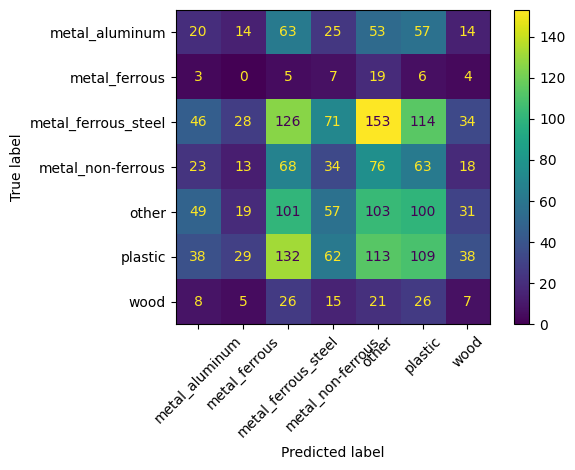

In [17]:
# Plot confusion matrix of CNN: Test set

y_pred = model.predict(test_generator)
predicted_classes = np.argmax(y_pred, axis = 1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

reverse_mapping = {v:k for k,v in test_generator.class_indices.items()}

predicted_classes_str = [reverse_mapping[encoded] for encoded in predicted_classes]
true_classes_str = [reverse_mapping[encoded] for encoded in true_classes]

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)
show_confusion_matrix(predicted_classes_str,true_classes_str,classes = class_labels)

# KNN 

In [18]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [19]:
def get_file_names_list(folder_path): # Get file name from the folder path that have material subfolder
    file_names = []
    material_list = []
    material_names = ['metal_aluminum', 'metal_ferrous_steel','metal_ferrous','metal_non-ferrous','wood','other','plastic']
    for material in material_names:
        cur_folder = os.path.join(folder_path, material)
        files_path = get_all_files(cur_folder,"*")
        for file_path in files_path:
            file_name = os.path.basename(file_path)
            file_name = os.path.splitext(file_name)[0]
            file_names.append(file_name)
            material_list.append(material)
            
    return file_names, material_list

In [20]:
train_dir = r"./output/train/"     # current location of train directory
# List all files in the directory
file_names_train, mat_train = get_file_names_list(train_dir)


val_dir = r"./output/val/"     # current location of validation directory
# List all files in the directory
file_names_val, mat_val = get_file_names_list(val_dir)


test_dir = r"./output/test/"     # current location of test directory
# List all files in the directory
file_names_test, mat_test = get_file_names_list(test_dir)

In [21]:
# Get panda data frame from file names in train/val/test folders
df_bodyPart_train = pd.DataFrame(columns = col_ultimate)
df_bodyPart_val = pd.DataFrame(columns = col_ultimate)
df_bodyPart_test = pd.DataFrame(columns = col_ultimate)

# # -- Train set --
# for file_name in file_names_train:
for file_name in file_names_train:
   # Keyword to search for
    keyword = file_name

    # Create a boolean mask for matching rows
    mask = df_bodyPart['id'].str.contains(keyword, case=True)

    # Filter the DataFrame based on the mask
    # Use .loc to select matching row as a Series
    matching_row_series = df_bodyPart.loc[mask].iloc[0]

    # Convert the Series to a dictionary
    matching_row_dict = matching_row_series.to_dict()

    # create new dataframe with matching row
    matching_row_pd = pd.DataFrame([matching_row_dict])

    # Add the matching row pd to ultimate body part
    df_bodyPart_train = pd.concat([df_bodyPart_train, matching_row_pd], ignore_index=True)


# -- validation set (This will include into train set as well in KNN)--
for file_name in file_names_val:
   # Keyword to search for
    keyword = file_name
    # Create a boolean mask for matching rows
    mask = df_bodyPart['id'].str.contains(keyword, case=True)

    # Filter the DataFrame based on the mask
    # Use .loc to select matching row as a Series
    matching_row_series = df_bodyPart.loc[mask].iloc[0]

    # Convert the Series to a dictionary
    matching_row_dict = matching_row_series.to_dict()

    # create new dataframe with matching row
    matching_row_pd = pd.DataFrame([matching_row_dict])

    # Add the matching row pd to ultimate body part
    # df_bodyPart_val = pd.concat([df_bodyPart_val, matching_row_pd], ignore_index=True)
    df_bodyPart_train = pd.concat([df_bodyPart_train, matching_row_pd], ignore_index=True)

# -- test set --
for file_name in file_names_test:
    # Keyword to search for
    keyword = file_name
    # Create a boolean mask for matching rows
    mask = df_bodyPart['id'].str.contains(keyword, case=True)

    # Filter the DataFrame based on the mask
    # Use .loc to select matching row as a Series
    matching_row_series = df_bodyPart.loc[mask].iloc[0]

    # Convert the Series to a dictionary
    matching_row_dict = matching_row_series.to_dict()

    # create new dataframe with matching row
    matching_row_pd = pd.DataFrame([matching_row_dict])

    # Add the matching row pd to ultimate body part
    df_bodyPart_test = pd.concat([df_bodyPart_test, matching_row_pd], ignore_index=True)

df_bodyPart_train = df_bodyPart_train.fillna(0) # fill NaN with 0 
# df_bodyPart_val = df_bodyPart_val.fillna(0)
df_bodyPart_test = df_bodyPart_test.fillna(0)


In [22]:
# Features and target variable
features = col_ultimate[2:len(col_ultimate)-1] # feature: Remove ID,name, and material 
# features = ['area', 'volume', 'normalized_joints', 'normalized_contacts', 'normalized_holes']
target = 'material'

# Shuffle the rows (for training)
df_bodyPart_train = df_bodyPart_train.sample(frac=1).reset_index(drop=True)
df_bodyPart_test = df_bodyPart_test.sample(frac=1).reset_index(drop=True)

# Encode the 'material' column
label_encoder = LabelEncoder()
df_bodyPart_train['material_encoded'] = label_encoder.fit_transform(df_bodyPart_train[target])
# df_bodyPart_val['material_encoded'] = label_encoder.fit_transform(df_bodyPart_val[target])
df_bodyPart_test['material_encoded'] = label_encoder.fit_transform(df_bodyPart_test[target])

# scaling the features
# Initialize the transformer (e.g., StandardScaler)
scaler = StandardScaler()

# Fit the transformer to the first DataFrame
scaler.fit(df_bodyPart_train[features])


# df_bodyPart_train[features] = scaler.fit(df_bodyPart_train)

# Transform both DataFrames using the same normalization parameters
df_bodyPart_train[features] = pd.DataFrame(scaler.transform(df_bodyPart_train[features]))
df_bodyPart_test[features] = pd.DataFrame(scaler.transform(df_bodyPart_test[features]))

                     precision    recall  f1-score   support

     Metal_Aluminum       0.61      0.59      0.60       187
      Metal_Ferrous       0.50      0.47      0.48       108
Metal_Ferrous_Steel       0.65      0.65      0.65       521
  Metal_Non-Ferrous       0.64      0.72      0.68       271
              Other       0.69      0.70      0.69       538
            Plastic       0.63      0.61      0.62       475
               Wood       0.64      0.57      0.60       146

           accuracy                           0.64      2246
          macro avg       0.62      0.62      0.62      2246
       weighted avg       0.64      0.64      0.64      2246



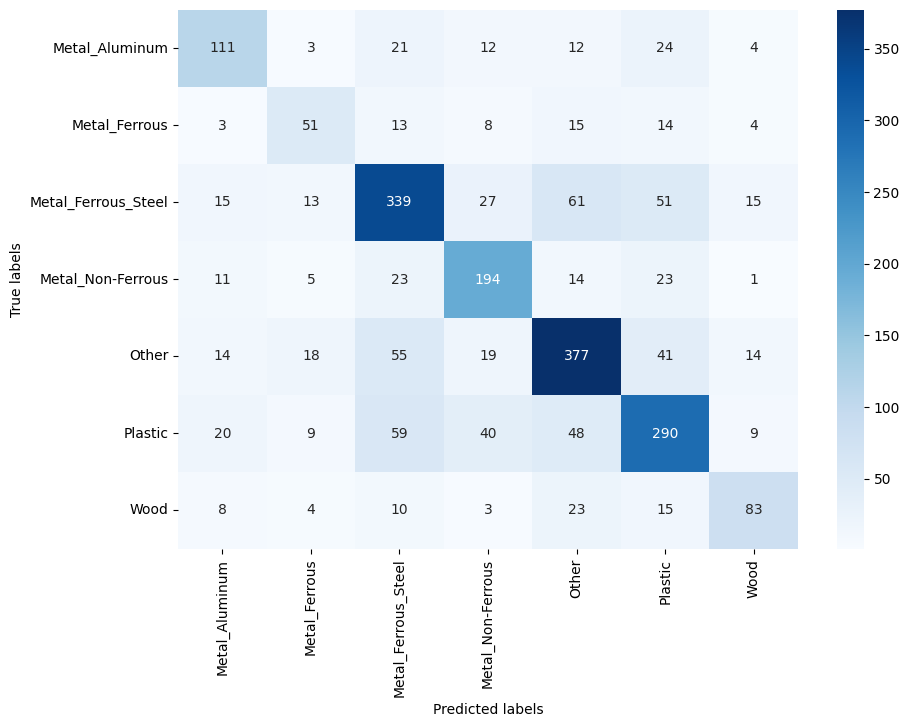

In [23]:
X_train = df_bodyPart_train[features]
X_test = df_bodyPart_test[features]
y_train = df_bodyPart_train[target]
y_test = df_bodyPart_test[target]


# Training KNN classifier
knn = KNeighborsClassifier(n_neighbors=7, weights='distance')
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Getting the label names from the LabelEncoder
labels = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

# Evaluation
print(classification_report(y_test, y_pred, target_names=labels))

# Generate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)
# print(confusion)



# Plot the confusion matrix using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [34]:
# correlation matrix to find significance of the parameters 
# Select only numeric columns
numeric_df = df_bodyPart_train.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

corr_matrix = corr_matrix["material_encoded"].sort_values(ascending=False)

corr_matrix = corr_matrix.fillna(0)
print(corr_matrix)
corr_matrix.to_csv('corr_matrix.csv')


material_encoded    1.000000
cat30               0.101804
cat17               0.096179
cat8                0.089134
cat14               0.079562
                      ...   
cat60               0.000000
cat67               0.000000
cat68               0.000000
cat69               0.000000
cat70               0.000000
Name: material_encoded, Length: 76, dtype: float64


# Test Set Compliation

In [24]:
input_dir_test = r"/Users/pat/Documents/Development/patbam/testSetCompile/Fusion360GalleryDataset_23hackathon_test/"     # Change this to the directory where you downloaded the dataset
input_jsons_test = get_all_files(input_dir_test, "*/assembly.json")

# Create new folder for collecting png for training (CNN Algorithm)
# In the future --> To improve automation --> Will automatatically create the folder
# output_dir_test = "/Users/pat/Documents/Development/patbam/PNG_NeuralNetwork"


In [25]:
# Create data frame for body part (for linking with KNN)
df_bodyPart_realTest = pd.DataFrame(columns = col_ultimate)

In [26]:
# Intentionally commented out the CNN data preparation since the results are not promising. Only use KNN for testing set

assemblies = {}
counter = 0
# desired_img_sz = (224, 224)  # Desired size of the image

for input_json in tqdm(input_jsons_test): # tqdm: to show the progress bar 

    with open(input_json, "r", encoding="utf-8") as f:
        assembly_data = json.load(f)

    bodies = []


 # -----------------------------------CONTACT--------------------------------------------------------------------- #
    # bodyCountContactDict: to count the number of contacts in each body
    bodyCountContactDict_key = list(assembly_data['bodies'].keys())
    len_bodyCountContactDict = len(bodyCountContactDict_key)
    bodyCountContactDict_value = [0]*len_bodyCountContactDict 
    bodyCountContactDict = dict(zip(bodyCountContactDict_key, bodyCountContactDict_value))     # Make dict type of counting  

    # ---- counting occurence in contact ----
    if 'contacts' in assembly_data.keys():
        
        if assembly_data['contacts'] is not None:
            for contacts in assembly_data['contacts']:
                for key2, value2 in contacts.items():
                    body1 = value2['body']
                    bodyCountContactDict[body1] += 1
    
    # -------------------------------------------------------------------------------------------------------- #


    # -----------------------------------Holes--------------------------------------------------------------------- #
    # bodyCountHoleDict: to count the number of holes in each body
    bodyCountHoleDict_key = list(assembly_data['bodies'].keys())
    len_bodyCountHoleDict = len(bodyCountHoleDict_key)
    bodyCountHoleDict_value = [0]*len_bodyCountHoleDict 
    bodyCountHoleDict = dict(zip(bodyCountHoleDict_key, bodyCountHoleDict_value))     # Make dict type of counting  

    # ---- counting occurence in contact ----
    if 'holes' in assembly_data.keys():
        
        if assembly_data['holes'] is not None:
            for holes in assembly_data['holes']:
                body1 = holes['body']
                bodyCountHoleDict[body1] += 1
    # -------------------------------------------------------------------------------------------------------- #

    # ------------------------------JOINT-------------------------------------------------------------------------- #
    # bodyCounJointDict: to count the number of joints in each body
    bodyCountJointDict_key = list(assembly_data['bodies'].keys())
    len_bodyCountJointDict = len(bodyCountJointDict_key)
    bodyCountJointDict_value = [0]*len_bodyCountJointDict 
    bodyCountJointDict = dict(zip(bodyCountJointDict_key, bodyCountJointDict_value))     # Make dict type of counting  

    # --- counting # of joints from each body in assembly ---
    occToBody = {}

    # ---- counting occurence in joint ----
    if 'joints' in assembly_data.keys():
        
        if assembly_data['joints'] is not None:
            
            # print(input_json)  # for debugging: check the cause of the error in assembly
                # ---- create dictionary of occurence --> body ----
            for key,value in assembly_data['occurrences'].items():                

                value_list = list(value.keys()) # list of key in an occurence

                if 'bodies' in value_list: 

                    if isinstance(value['bodies'], dict): # check if value of body is dict type
                        occToBody[key] = list(value['bodies'].keys())[0]
                    else:
                        occToBody[key] = value['bodies']

            for key2, value2 in assembly_data['joints'].items():
                value2_list = list(value2.keys())

                # check if occ1 exists
                if 'occurrence_one' in value2_list:
                    occ1 = value2['occurrence_one']
                    body1 = occToBody[occ1]
                    bodyCountJointDict[body1] += 1
                # check if occ2 exists
                if 'occurrence_two' in value2_list:
                    occ2 = value2['occurrence_two']
                    body2 = occToBody[occ2]
                    bodyCountJointDict[body2] += 1 
    # -------------------------------------------------------------------------------------------------------- #



    # ------------------------------------- category features ----------------------------------------------- #

    cat_row = [0]*len(category)

    if 'properties' in assembly_data.keys():
        cat = assembly_data['properties']['categories']
        for cat_item in cat:
            cat_ind = category.index(cat_item)
            cat_row[cat_ind] = 1


    # -------------------------------------------------------------------------------------------------------- #

    # ------ Prepare data for loading in dataframe  ---------------- 
    for key2, value2 in assembly_data['bodies'].items():

        name = value2.get('name', None)
        material = value2.get('material_category', None)
        area = value2.get('physical_properties', {}).get('area', None)
        volume = value2.get('physical_properties', {}).get('volume', None)
        id_body = key2


        if name[:4] != 'Body':  # Assuming you want to check if name is not None or empty

            num_joint = bodyCountJointDict[key2]
            num_contact = bodyCountContactDict[key2]
            num_hole = bodyCountHoleDict[key2]

        
            # Update/Add to DataFrame
            if name in df_bodyPart_realTest['name'].values:
                df_bodyPart_realTest.loc[df_bodyPart_realTest['name'] == name, 'normalized_joints'] += num_joint
                df_bodyPart_realTest.loc[df_bodyPart_realTest['name'] == name, 'normalized_contacts'] += num_contact
                df_bodyPart_realTest.loc[df_bodyPart_realTest['name'] == name, 'normalized_holes'] += num_hole
                for i in range(len(category)):
                    if 0 in df_bodyPart_realTest.loc[df_bodyPart_realTest['name'] == name, str('cat'+str(i+1))]:
                        if cat_row[i] == 1:
                            df_bodyPart_realTest.loc[df_bodyPart_realTest['name'] == name, 'cat'+str(i+1)] = 1
        

            else:
                df_curBody = {'id':id_body, 'name': name, 'area': area, 'volume': volume, 'normalized_joints': num_joint, 
                            'normalized_contacts': num_contact, 'normalized_holes': num_hole,'material': material}
                for i in range(len(category)):
                    df_curBody['cat'+str(i+1)] = cat_row[i]
                df_bodyPart_realTest.loc[len(df_bodyPart_realTest)] = df_curBody
                png_name = value2['png']


                # # ----------For categorizing the pictures to material base ---------------------- # -- UNCOMMENT THIS FOR SUBMISSION
                # if material == "Metal_Aluminum":
                #     destination_path = output_dir + "/metal_aluminum/" +  png_name
                # elif material == "Metal_Ferrous_Steel":
                #     destination_path = output_dir + "/metal_ferrous_steel/" +  png_name
                # elif material == "Metal_Non-Ferrous":
                #     destination_path = output_dir + "/metal_non-ferrous/" +  png_name
                # elif material == "Metal_Ferrous":
                #     destination_path = output_dir + "/metal_ferrous/" +  png_name
                # elif material == "Wood":
                #     destination_path = output_dir + "/wood/" +  png_name       
                # elif material == "Plastic":
                #     destination_path = output_dir + "/plastic/" +  png_name
                # else:
                #     destination_path = output_dir + "/other/" +  png_name


                # # ---- copy png file with resized to PNG_NeuralNetwork  ----
                # # Get the source path
                # # cur_json = str(input_json)
                # # cur_folder = cur_json.replace("assembly.json", "")



                # # Remove "assembly.json" by getting the parent directories
                # cur_folder = input_json.parents[0] / input_json.name.replace("assembly.json", "")

                # source_path = os.path.join(cur_folder, png_name)


                # # Open the image using PIL
                # image = Image.open(source_path)

                # # Resize the image while maintaining aspect ratio
                # image.thumbnail(desired_img_sz, Image.ANTIALIAS)

                # #destination_path = os.path.join(output_dir, png_name)

                # #shutil.copy(source_path, destination_path) # this is for the copy
                # image.save(destination_path)

                # # ----------------------------------------------------------------------- #
        
        

    if len(bodies) > 0:
        assemblies[input_json.parts[-2]] = bodies
    counter +=1 

100%|██████████| 10/10 [00:00<00:00, 27.11it/s]


In [27]:
# Features and target variable

df_bodyPart_realTest = df_bodyPart_realTest.fillna(0) # fill NaN with 0 
features = col_ultimate[2:len(col_ultimate)-1] # feature: Remove ID,name, and material 

# scaling the features with respect to the train set
df_bodyPart_realTest[features] = pd.DataFrame(scaler.transform(df_bodyPart_realTest[features]))

In [28]:
# Read the csv file
# Read data from a CSV file and create a DataFrame
df = pd.read_csv('./submission/submission_CYBERPATH.csv')
features = col_ultimate[2:len(col_ultimate)-1] 


# Display the first few rows of the DataFrame
# Loop through each row and modify values
counter = 0
for index, row in df.iterrows():
    # Search for keyword from body_id
    keyword = row['body_id']

    # open the folder with json file
    json_name = row['assembly_id']
    json_loca = input_dir_test + json_name + '/assembly.json'

    with open(json_loca, "r", encoding="utf-8") as f:
        assembly_data = json.load(f)
    
    
    for key2, value2 in assembly_data['bodies'].items():
        if key2 == keyword:
            keyword_name = value2['name']
            if keyword_name[:4] == 'Body':
                df.loc[index, 'material_category'] = 'NA'
            else: 
                mask = df_bodyPart_realTest['name'] == keyword_name
                filtered_rows = df_bodyPart_realTest[mask].copy()
        

                X_test = filtered_rows[features]

        
                y_pred = knn.predict(X_test)
                y_pred = str(y_pred[0])
                
                y_pred = y_pred.lower()
                # y_pred = id2name(y_pred)

                df.loc[index, 'material_category'] = y_pred


df.to_csv('./submission/submission_CYBERPATH.csv')